# Caso de uso para trabajo fin de grado: Analisis de estrategias clustering en la economía
En este cuaderno se va a realizar un caso de uso vinculado a la segmentación de clientes

# 1. Imports
Se importan las librerias y funciones que se van a utilizar en este caso de uso


In [52]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import RandomState
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from scipy.stats import mode
from collections import Counter


# 2. Selección de datos
En este caso, la selección es del computo total de datos que se dispone

In [53]:
datos = pd.read_excel('customer-set.xlsx', header = 0)
datos = datos.drop(['Unnamed: 0'], axis = 1)

Echamos un vistazo al dataset cargado:

In [54]:
datos.head(5) 

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Category 4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Category 6
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Category 6


Comprobamos las dimensiones del dataset:

In [55]:
datos.shape 

(8068, 10)

# 3. Analisis exploratorio de los datos y preprocesado de datos 

## 3.1. Valores perdidos

In [56]:
## Genero una mascara booleana con True donde se encuentran los valores perdidos.
is_NaN = datos.isnull()
registro_con_NaN = is_NaN.any(axis=1)

## Filtro los datos para recuperar solamente los registros con valores perdidos.
registro_con_NaN = datos[registro_con_NaN]
registro_con_NaN

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Category 4
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Category 6
12,461230,Female,No,19,No,Executive,0.0,Low,NaN,Category 3
13,459573,Male,Yes,70,No,Lawyer,NaN,Low,1.0,Category 6
24,461021,Female,NaN,58,No,Executive,1.0,Average,3.0,Category 3
...,...,...,...,...,...,...,...,...,...,...
8040,467165,Female,No,25,No,Homemaker,NaN,Low,1.0,Category 6
8044,466997,Female,NaN,50,No,Engineer,1.0,Low,2.0,Category 6
8047,462396,Male,Yes,50,Yes,Doctor,NaN,Average,2.0,Category 6
8049,461292,Female,Yes,81,No,Lawyer,NaN,High,2.0,Category 3


Se tienen 1403 registros de cliente con valores perdidos. El siguiente paso es imputar algun valor para reconocerlos y evitar el valor NaN. Los imputaremos con el valor 'Perdido'.

In [57]:
datos = datos.fillna("Perdido") 

Podemos comprobar de nuevo el conjunto de datos para comprobar la sustitucion de valores

In [58]:
datos.head(3) 

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Category 4
1,462643,Female,Yes,38,Yes,Engineer,Perdido,Average,3.0,Category 4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Category 6


## 3.2. Analisis de datos.
Con el fin de entender mejor nuestros datos y saber situarnos dentro del problema, se generarán graficos para cada variable.

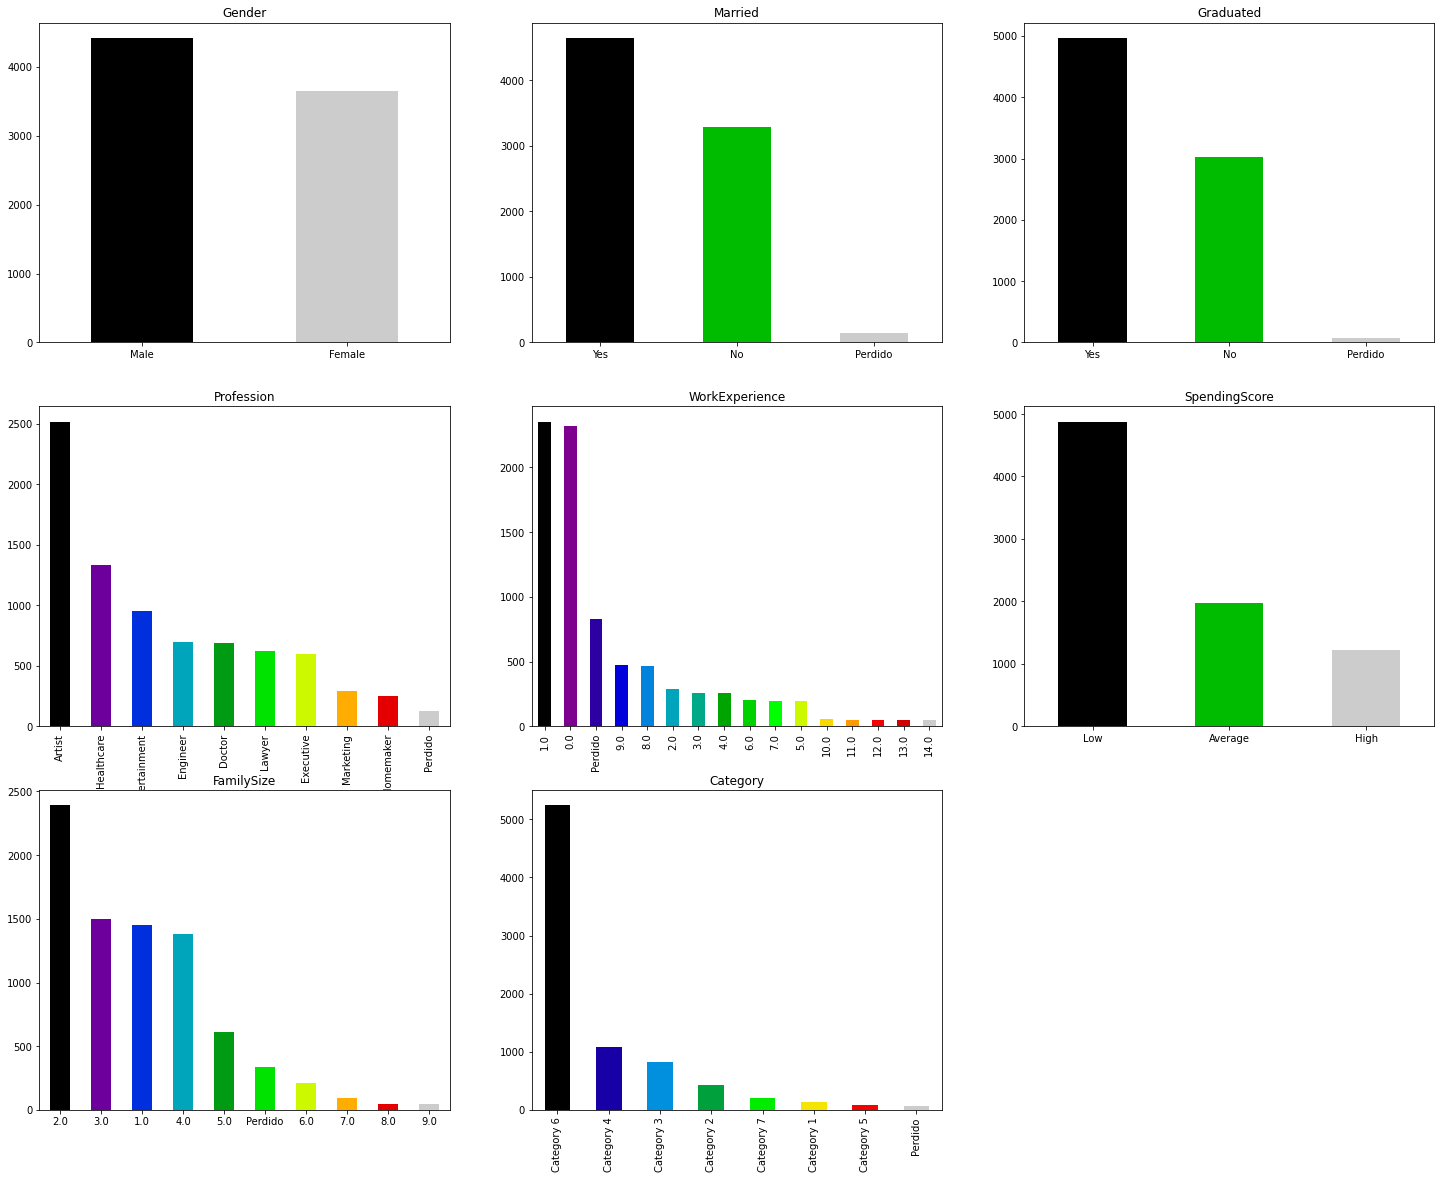

In [59]:
## Definicion de la funcion que ploteará las gráficas.
def grafica(fig, subplot_id, columna, mapa_color, rotacion_etiquetas):
    fig.add_subplot(subplot_id)
    long_color = len(datos[columna].unique())
    color = mapa_color(np.linspace(0, 1, long_color))
    count = datos[columna].value_counts()
    plt.title(columna)
    count.plot(kind='bar', color=color)
    plt.xticks(rotation=rotacion_etiquetas)
    # plt.ylabel("Count")
    
fig = plt.figure(figsize=(25, 20))
grafica(fig, 331, "Gender", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 332, "Married", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 333, "Graduated", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 334, "Profession", plt.cm.nipy_spectral, "vertical")
grafica(fig, 335, "WorkExperience", plt.cm.nipy_spectral, "vertical")
grafica(fig, 336, "SpendingScore", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 337, "FamilySize", plt.cm.nipy_spectral, "horizontal")
grafica(fig, 338, "Category", plt.cm.nipy_spectral, "vertical")
plt.show()

Para visualizar la edad, como puede tener muchos valores diferentes, se definen intervalos. En concreto se han establecido 9 intervalos

In [60]:
## Número de intervalos
i = 9
intervalos = [0, 
        int(max(datos['Age'])/i), 
        int(2*max(datos['Age'])/i), 
        int(3*max(datos['Age'])/i), 
        int(4*max(datos['Age'])/i), 
        int(5*max(datos['Age'])/i), 
        int(6*max(datos['Age'])/i), 
        int(7*max(datos['Age'])/i),
       int(8*max(datos['Age'])/i),
        max(datos['Age'])]

intervalos_edad = pd.cut(datos['Age'], bins=intervalos)

In [61]:

## Agrupamos los datos segun el genero e intervalo de edad.
groupby_df = datos.groupby(['Gender', intervalos_edad]).size().reset_index(name='Count')

## Creamos mascaras booleanas para la selección
mascara_mujeres = groupby_df['Gender']=="Female"
mascara_hombres = groupby_df['Gender']=="Male"

## Seleccionamos aplicando las mascaras definidas anteriormente
mujeres_df = groupby_df.loc[mascara_mujeres]
hombres_df = groupby_df.loc[mascara_hombres]

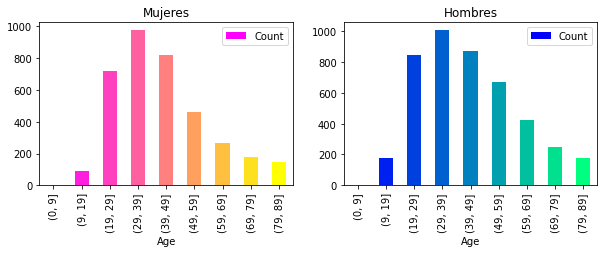

In [62]:
## Configuramos la figura que se va a mostrar. Concretamente dos subfiguras.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

## Elegimos la paleta de color para la visualización
color_mujeres = plt.cm.spring(np.linspace(0, 1, len(mujeres_df['Age'].unique())))
color_hombres = plt.cm.winter(np.linspace(0, 1, len(hombres_df['Age'].unique())))

## Generamos las subfiguras
mujeres_df.plot(x='Age', y='Count', kind = 'bar', color=color_mujeres, title='Mujeres', ax=axes[0])
hombres_df.plot(x='Age', y='Count', kind = 'bar', color=color_hombres, title='Hombres', ax=axes[1])

## Por ultimo mostramos la figura completa
plt.show()

## 3.3 Preprocesado de datos

### 3.3.1 Transformación de los datos

In [63]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      8068 non-null   int64 
 1   Gender          8068 non-null   object
 2   Married         8068 non-null   object
 3   Age             8068 non-null   int64 
 4   Graduated       8068 non-null   object
 5   Profession      8068 non-null   object
 6   WorkExperience  8068 non-null   object
 7   SpendingScore   8068 non-null   object
 8   FamilySize      8068 non-null   object
 9   Category        8068 non-null   object
dtypes: int64(2), object(8)
memory usage: 630.4+ KB


Para emplear las variables categoricas no numericas en las técnicas de clustering, es necesario realizar la transformacion a variables categoricas numéricas. Esto se consigue con la funcion factorize de la libreria Pandas.

In [64]:
datos["Gender"] = pd.factorize(datos["Gender"])[0]
datos["Married"] = pd.factorize(datos["Married"])[0]
datos["Graduated"] = pd.factorize(datos["Graduated"])[0]
datos["Profession"] = pd.factorize(datos["Profession"])[0]
datos["SpendingScore"] = pd.factorize(datos["SpendingScore"])[0]
datos["Category"] = pd.factorize(datos["Category"])[0]

### 3.3.2 Imputacion de valores perdidos

Para evitar los valores perdidos en la ejecucion de las tecnicas de clustering, se procede a imputar los valores 'Perdidos' por la moda en columnas numericas.

In [65]:
datos["WorkExperience"] = datos["WorkExperience"].replace("Perdido",datos["WorkExperience"].mode()[0])
datos["FamilySize"] = datos["FamilySize"].replace("Perdido",datos["FamilySize"].mode()[0])

Podemos comprobar la sustitucion de los valores

In [66]:
datos.head(5) 

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,462809,0,0,22,0,0,1.0,0,4.0,0
1,462643,1,1,38,1,1,1.0,1,3.0,0
2,466315,1,1,67,1,1,1.0,0,1.0,1
3,461735,0,1,67,1,2,0.0,2,2.0,1
4,462669,1,1,40,1,3,1.0,2,6.0,1


### 3.3.3 Normalización de los datos
La normalización nos permite corregir el posible sesgo de los algoritmos hacia ciertas variables debido a sus escalas, ya que los algoritmos trabajan con calculo de distancias.

In [67]:
datos

,CustomerID,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,462809,0,0,22,0,0,1.0,0,4.0,0
1,462643,1,1,38,1,1,1.0,1,3.0,0
2,466315,1,1,67,1,1,1.0,0,1.0,1
3,461735,0,1,67,1,2,0.0,2,2.0,1
4,462669,1,1,40,1,3,1.0,2,6.0,1
...,...,...,...,...,...,...,...,...,...,...
8063,464018,0,0,22,0,9,0.0,0,7.0,4
8064,464685,0,0,35,0,5,3.0,0,4.0,0
8065,465406,1,0,33,1,0,1.0,0,1.0,1
8066,467299,1,0,27,1,0,1.0,0,4.0,1


In [68]:
## Normalizaremos los datos al intervalo [0,1]
scaler = MinMaxScaler(feature_range=(0, 1)) 

#Normalizaremos todas la variables menos la identificativa de cada cliente
datos_normalizados = datos.drop(['CustomerID'],axis=1,)

## Adicionalmente, para la visualizacion haremos uso del dataframe sin normalizar pero sin la columna idenqificativa, por lo 
## se le quita y se guarda en otro datafrme

datos_sin_ID = datos.drop(['CustomerID'],axis=1,).copy()
usadas = ['Genero','Casado','Edad','Graduado','Profesion','ExperienciaLaboral','Score','Familia','Categoria']
datos_sin_ID.columns = usadas
num_var = len(datos_sin_ID.columns)

In [69]:
datos_normalizados

,Gender,Married,Age,Graduated,Profession,WorkExperience,SpendingScore,FamilySize,Category
0,0,0,22,0,0,1.0,0,4.0,0
1,1,1,38,1,1,1.0,1,3.0,0
2,1,1,67,1,1,1.0,0,1.0,1
3,0,1,67,1,2,0.0,2,2.0,1
4,1,1,40,1,3,1.0,2,6.0,1
...,...,...,...,...,...,...,...,...,...
8063,0,0,22,0,9,0.0,0,7.0,4
8064,0,0,35,0,5,3.0,0,4.0,0
8065,1,0,33,1,0,1.0,0,1.0,1
8066,1,0,27,1,0,1.0,0,4.0,1


In [70]:
datos_normalizados = scaler.fit_transform(datos_normalizados)
datos_normalizados


array([[0.        , 0.        , 0.05633803, ..., 0.        , 0.375     ,
        0.        ],
       [1.        , 0.5       , 0.28169014, ..., 0.5       , 0.25      ,
        0.        ],
       [1.        , 0.5       , 0.69014085, ..., 0.        , 0.        ,
        0.14285714],
       ...,
       [1.        , 0.        , 0.21126761, ..., 0.        , 0.        ,
        0.14285714],
       [1.        , 0.        , 0.12676056, ..., 0.        , 0.375     ,
        0.14285714],
       [0.        , 0.5       , 0.26760563, ..., 0.5       , 0.25      ,
        0.        ]])

In [71]:
## Construyo un nuevo datframe con los datos normalizados. 
df_normalizado = pd.DataFrame(data=datos_normalizados, columns=usadas)
df_normalizado.head() # check the result
df_normalizado.columns = usadas

# 4. Minería de datos. Clustering

Se van a aplicar las siguientes tecnicas de clustering sobre los datos:
- Clustering particional: K-means, Meanshift
- Clustering jerarquico: Clustering agglomerativo
- Clustering basado en densidad: DBSCAN, OPTICS
- Clustering probabilistico: 

## 4.1 Estudio del numero de clúster optimo para técnicas particionales (K-means) y estudio de parámetros para clusterings basados en densidad
Para realizar el estudio del numero optimo de cluteres, se va a llevar a cabo el método del codo. Este calcula el error cuadratico medio. Se obtendrá una grafica donde en el eje x se representan los valores de K y en el eje y los valores de dicho error. El valor de K optimo se encuentra donde la curva deja de ser lineal para tener un comportamiento mas curvo.

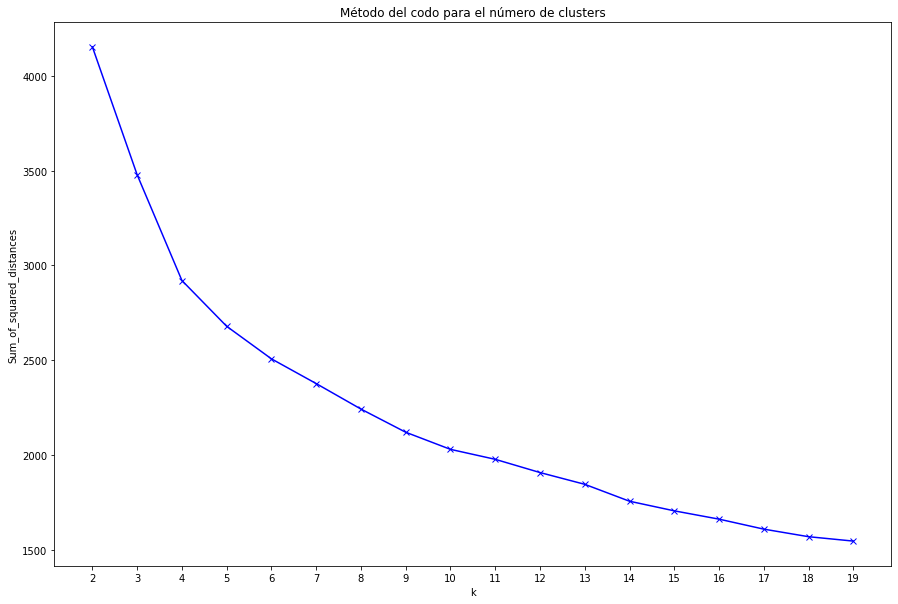

In [72]:
Sum_of_squared_distances = []
K = range(2,20)
for k in K:
   km_nombres = KMeans(n_clusters=k, max_iter=300, n_init=10)
   km_nombres = km_nombres.fit(df_normalizado)
   Sum_of_squared_distances.append(km_nombres.inertia_)
   
plt.figure(figsize=(15,10))
plt.xticks(range(20))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Método del codo para el número de clusters')
plt.savefig('metodo_del_codo.png')
plt.show()

Se comprueba que la linealidad se pierde en el valor de K = 4. Escogeremos este valor como numero optimo de clusteres.

In [73]:
K = 4

Ahora haremos el estudio de los parametros para DBSCAN y OPTICS sabiendo que nuestro numero de cluster esperado óptimo es 4.

Para el estudio de parámetros de DBSCAN y OPTICS es neccesario evaluar de alguna manera la ejecucion del algoritmo para los diversos valores de los parametros. La manera que en la que se van a evaluar va a ser el desarrollo de mapas de calor con los que visualizar como varia la metrica escogida (INDICE DE CALINSKI HARABASZ). Esta métrica se valora de la siguiente forma: el peor valor posible es 0, cuanto mayor sea el valor , mejor indicativo de similitud entre ejemplos del mismo cluser y de diferenciacion con los de los demas clusters.

In [74]:
def Calinski_Harabasz(df_normalizado, cluster_predict):
    metric_CH = metrics.calinski_harabasz_score(df_normalizado, cluster_predict)
    return metric_CH

In [75]:
for e in range(1,12,1):
    print(e)

1
2
3
4
5
6
7
8
9
10
11


Empezaremos por DBSCAN:

In [76]:
eps_range = np.arange(0.4, 0.95, 0.05)
x_index = eps_range
pts_range = range(1,12,1)
y_index = pts_range
lista = []

for n in eps_range:
  for p in pts_range:
    print(n,p)
    dbscan = DBSCAN(eps=n,min_samples=p)
    dbscan.fit(df_normalizado)
    CH = Calinski_Harabasz(df_normalizado, dbscan.labels_)
    if(len(set(dbscan.labels_)) == 1): ## No queremos un solo cluster.
      CH = 0
    lista.append(CH)
  
N=11
matrix = [lista[n:n+N] for n in range(0,121,N)]

hm = pd.DataFrame(data=matrix,index=x_index,columns=pts_range)

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(hm, square=True, ax=ax, cmap="YlGnBu")
plt.yticks(rotation=0,fontsize=16);
plt.xticks(fontsize=12);
plt.tight_layout()
plt.savefig('heatmap_CH.png')

0.4 1
0.4 2
0.4 3
0.4 4
0.4 5
0.4 6
0.4 7
0.4 8
0.4 9
0.4 10
0.4 11
0.45 1
0.45 2
0.45 3
0.45 4
0.45 5
0.45 6
0.45 7
0.45 8
0.45 9
0.45 10
0.45 11
0.5 1
0.5 2
0.5 3
0.5 4
0.5 5
0.5 6
0.5 7
0.5 8


KeyboardInterrupt: 

Ahora sabemos que para las mejores ejecuciones del algoritmo los valores deben encontrarse en los siguientes rangos:

eps ->[0.825,0.95]
minpts -> [1,10]

Como vemos, es bastante dependiente del radio eps.

¿Y si quisieramos saber cual es el numero optimo de cluster?
Teniendo la calida del agrupamiento segun CH, ejecutaremos el algoritmo para los intervalos anteriores de parametros y veremos cuantos clusters se generan.

In [ ]:
num_clusters = []
eps = np.arange(0.8, 1.0, 0.025)
m_samples = range(1, 12, 1)
for e in eps:
   for m in m_samples:
      print(e,m)
      dbscan = DBSCAN(eps=e, min_samples=m)
      dbscan.fit(df_normalizado)
      num_clusters.append(len(set(dbscan.labels_)))

print(num_clusters)

In [ ]:
print(Counter(num_clusters).keys())
print(Counter(num_clusters).values())

dict_keys([3, 2])
dict_values([22, 66])


Se puede observar que el numero optimo de clusters para dbscan, de forma que se maximice su rendimiento es de 2 o 3. Por lo que estableceremos sus parametros de la siguiente manera:

- eps         -> 0.875
- min_samples -> 3

El valor bajo de min_samples optimiza el numero de calculos de distancia necesarios para establecer un cluster.

Dado que OPTICS es dependendiente de DBSCAN por usarlo como tecnica de clusterización. Utilizaremos los mismos parámetros pero esta vez, EPS sera usado como parametro max_eps.

In [77]:
EPS = 0.875
MIN_SAMPLES = 3

## 4.2 Clustering

### 4.2.1. Instanciacion de los objetos para realizar el clustering

In [78]:
## KMEANS
kmeans = KMeans(n_clusters=K, random_state=0, max_iter=300, n_init=10, verbose=False)

## MEANSHIFT
bw = estimate_bandwidth(df_normalizado, quantile=0.25, n_samples = 500, random_state = 123456)
meanshift = MeanShift(bandwidth=bw, bin_seeding=True)

## CLUSTERING AGLOMERATIVO
clustering_aglomerativo = AgglomerativeClustering(n_clusters=K, affinity = 'euclidean', linkage='ward')
 
 
## DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=10)

## OPTICS
optics = OPTICS(min_samples=MIN_SAMPLES, cluster_method='dbscan',max_eps=EPS)

#CLUSTERING PROBABILISTICO
gm = GaussianMixture(n_components=K, random_state=0, init_params='random')

### 4.2.2 Ejecución

 Etiquetas K-MEANS =  [0 2 1 ... 1 1 3]
Número de clusteres diferentes =  4
 Etiquetas MEANSHIFT =  [0 1 1 ... 1 1 0]
Número de clusteres diferentes =  2
Etiquetas AGGLOMERATIVO  =  [0 3 1 ... 1 1 2]
Número de clusteres diferentes =  4


/Users/adriancarmona/Desktop/ADE_TFG_REPO/Analisis-de-estrategias-de-clustering-en-la-economia/segmentacion/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Etiquetas DBSCAN  =  [0 1 1 ... 1 1 0]
Número de clusteres diferentes =  2
Etiquetas OPTICS  =  [0 1 1 ... 1 1 0]
Número de clusteres diferentes =  2
Etiquetas Expc-Max  =  [0 0 1 ... 0 0 0]
Número de clusteres diferentes =  4


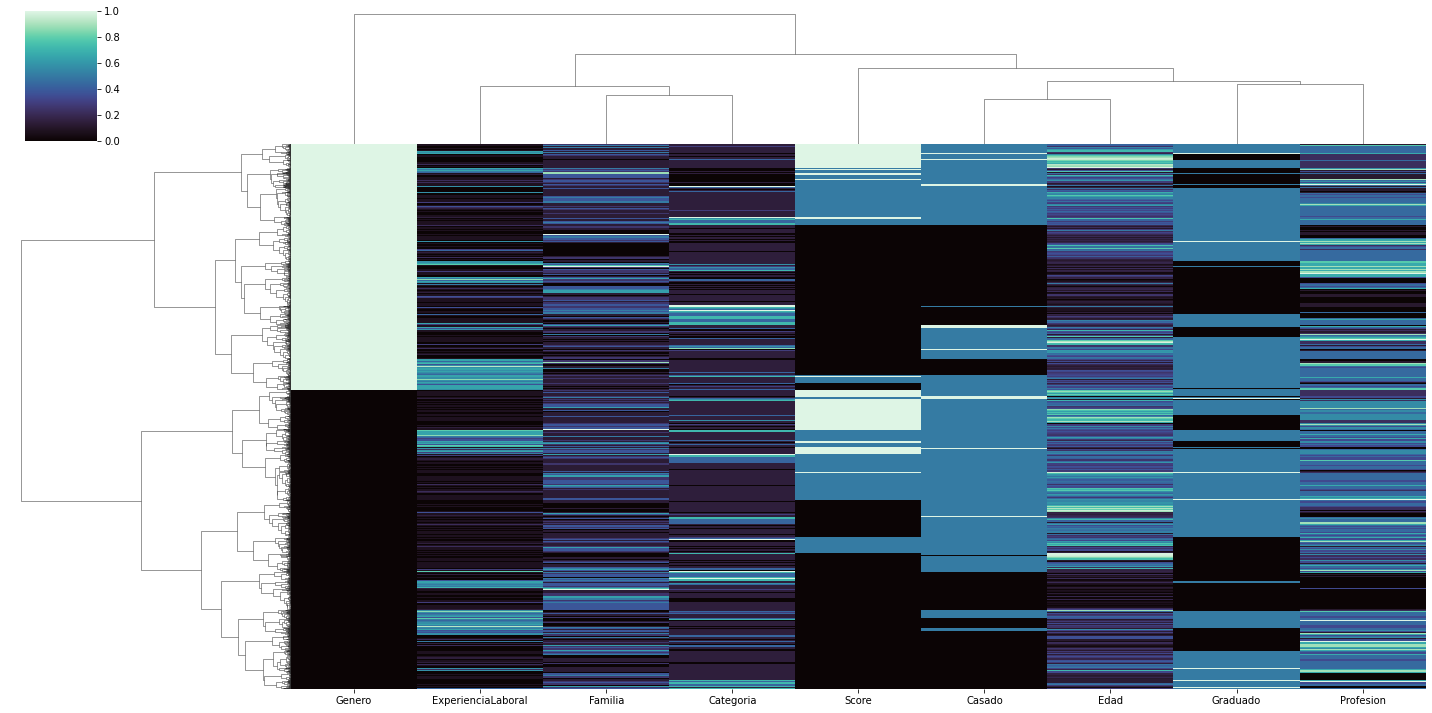

In [79]:

# LLAMADA AL METODO FIT.

## KMEANS
kmeans.fit(df_normalizado)
kmeans_labels = kmeans.labels_
print(" Etiquetas K-MEANS = ", kmeans_labels)
print('Número de clusteres diferentes = ', len(set(kmeans_labels)))

## MEANSHIFT
meanshift.fit(df_normalizado)
meanshift_labels = meanshift.labels_
print(" Etiquetas MEANSHIFT = ", meanshift_labels)
print('Número de clusteres diferentes = ', len(set(meanshift_labels)))

## CLUSTERING AGLOMERATIVO
clustering_aglomerativo.fit(df_normalizado)
clustering_aglomerativo_labels = clustering_aglomerativo.labels_
print("Etiquetas AGGLOMERATIVO  = ", clustering_aglomerativo_labels)
print('Número de clusteres diferentes = ', len(set(clustering_aglomerativo_labels)))

sns.clustermap(df_normalizado, method='ward', figsize=(20,10), cmap="mako", yticklabels=False)
plt.savefig("dendrograma.png")

## DBSCAN
dbscan.fit(df_normalizado)
dbscan_labels = dbscan.labels_
print("Etiquetas DBSCAN  = ", dbscan_labels)
print('Número de clusteres diferentes = ', len(set(dbscan_labels)))

## OPTICS
optics.fit(df_normalizado)
optics_labels = optics.labels_
print("Etiquetas OPTICS  = ", optics_labels)
print('Número de clusteres diferentes = ', len(set(optics_labels)))

#CLUSTERING PROBABILISTICO

gm_labels = gm.fit_predict(df_normalizado)
print("Etiquetas Expc-Max  = ", gm_labels)
print('Número de clusteres diferentes = ', len(set(gm_labels)))


# 5. Evaluación e interpretación de los resultados


## 5.1 Previsualización de resultados
En este apartado se definen funciones auxiliares para la creacion de las visualizaciones. Se han obtenido de la práctica 2 de la asignatura Inteligencia de Negocio del Grado en Ingenieria Informatica. Más concretamente de la mencion de sistemas de información.

Ademas de la definicion de las funciones, se hace uso de ellas para tratar los datos de manera que las funciones que crean las visualizaciones sean mas compactas y esten aisladas. Esto permite su reutilización.

### 5.1.1 Definicion de funciones

In [80]:
def converse_clusters_to_dataframe(cluster_predict,X_normal):
    clusters = pd.DataFrame(cluster_predict,index=X_normal.index,columns=['cluster'])
    return clusters

def get_clusters_centers_desnormal_kmeans_meanshift(k_means,X):
    centers = pd.DataFrame(k_means.cluster_centers_ ,columns=list(X))
    centers_desnormal = centers.copy()
    for var in list(centers):
        centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())
    return centers, centers_desnormal

def get_clusters_centers_desnormal(centers_normal,X):
    centers_desnormal = centers_normal.copy()
    for var in list(centers_normal):
        centers_desnormal[var] = X[var].min() + centers_normal[var] * (X[var].max() - X[var].min())
    return centers_desnormal

def get_cluster_sizes(clusters_df):
    print("Tamaño de cada cluster:")
    size=clusters_df['cluster'].value_counts()
    for num,i in size.iteritems():
        print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters_df)))
    return size

def set_colors(size):
    k = len(size)
    colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
    return colors,k

def scatter_matrix(X_clusters, colors):
    sns.set()
    variables = list(X_clusters)
    variables.remove('cluster')
    sns_plot = sns.pairplot(X_clusters, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    
def boxplot_axes_config(k,n_var):
    fig, axes = plt.subplots(k, n_var, sharey=True,figsize=(15,15))
    fig.subplots_adjust(wspace=0,hspace=0)
    return fig,axes

def boxplot(X_clusters,k, colors,axes, centers_sort,usadas):
    rango = []
    for j in range(num_var):
        rango.append([X_clusters[usadas[j]].min(),X_clusters[usadas[j]].max()])
    for i in range(k):
        
        c = centers_sort.index[i].astype(int)## astype(int) necesario para aquellos algortimos en los que los centroides se obtienen a partir de .mean().
        
        dat_filt = X_clusters.loc[X_clusters['cluster']==c]
        for j in range(num_var):
           
            ax = sns.boxplot(x=dat_filt[usadas[j]], notch=True, color=colors[c], flierprops={'marker':'o','markersize':4}, ax=axes[i,j])

            if (i==k-1):
                axes[i,j].set_xlabel(usadas[j])
            else:
                axes[i,j].set_xlabel("")
        
            if (j==0):
               axes[i,j].set_ylabel("Cluster "+str(c))
            else:
                axes[i,j].set_ylabel("")
        
            axes[i,j].set_yticks([])
            axes[i,j].grid(axis='x', linestyle='-', linewidth='0.2', color='gray')
            axes[i,j].grid(axis='y', b=False)
        
            ax.set_xlim(rango[j][0]-0.05*(rango[j][1]-rango[j][0]),rango[j][1]+0.05*(rango[j][1]-rango[j][0]))

def heatmap(centers, centers_desnormal):
    print("---------- Heatmap...")
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    centers.index -= 1



### 5.1.2 Tratamiento previo a la visualización

Para cada técnica:

- Convierto las series que contienen las etiquetas a objetos dataframe .
- Concateno dichos dataframes al dataframe sin normalizar (no queremos visualizar los datos normalizados, sino con sus valores originales).
- Calculo y muestro el tamaño de los clusters.
- Creo los colores para la visualizacion.
- Obtengo los centroides de los grupos. Estos son puntos que caracterizan de alguna forma a cada cluster.
- Ordeno los centroides para la visualizacion de boxplots
- Configuro los colores y ejes para los boxplots

In [82]:
df_normalizado

,Genero,Casado,Edad,Graduado,Profesion,ExperienciaLaboral,Score,Familia,Categoria
0,0.0,0.0,0.056338,0.0,0.000000,0.071429,0.0,0.375,0.000000
1,1.0,0.5,0.281690,0.5,0.111111,0.071429,0.5,0.250,0.000000
2,1.0,0.5,0.690141,0.5,0.111111,0.071429,0.0,0.000,0.142857
3,0.0,0.5,0.690141,0.5,0.222222,0.000000,1.0,0.125,0.142857
4,1.0,0.5,0.309859,0.5,0.333333,0.071429,1.0,0.625,0.142857
...,...,...,...,...,...,...,...,...,...
8063,0.0,0.0,0.056338,0.0,1.000000,0.000000,0.0,0.750,0.571429
8064,0.0,0.0,0.239437,0.0,0.555556,0.214286,0.0,0.375,0.000000
8065,1.0,0.0,0.211268,0.5,0.000000,0.071429,0.0,0.000,0.142857
8066,1.0,0.0,0.126761,0.5,0.000000,0.071429,0.0,0.375,0.142857


In [ ]:
## KMEANS
## MEANSHIFT
## CLUSTERING AGLOMERATIVO
## DBSCAN
## OPTICS
#CLUSTERING PROBABILISTICO
##TODO: separar lo de fig y axes. Arreglar boxplot  no pinta nada.

## KMEANS
clusters_df_kmeans                                      = converse_clusters_to_dataframe(kmeans_labels,df_normalizado)
df_normalizado_kmeans_clusters                          = pd.concat([datos_sin_ID, clusters_df_kmeans], axis=1)
size_cluster_kmeans                                     = get_cluster_sizes(clusters_df_kmeans)
colors_kmeans,k_kmeans                                  = set_colors(size_cluster_kmeans)
centroides_kmeans, centroides_desnormalizados_kmeans    = get_clusters_centers_desnormal_kmeans_meanshift(kmeans,datos_sin_ID)
centroides_desnormalizados_kmeans_sort                  = centroides_desnormalizados_kmeans.sort_values(by=['Edad'])
fig_kmeans,axes_kmeans                                  = boxplot_axes_config(k_kmeans,num_var)

## MEANSHIFT
clusters_df_meanshift                                           = converse_clusters_to_dataframe(meanshift_labels,df_normalizado)
df_normalizado_meanshift_clusters                               = pd.concat([datos_sin_ID, clusters_df_meanshift], axis=1)
size_cluster_meanshift                                          = get_cluster_sizes(clusters_df_meanshift)
colors_meanshift, k_meanshift                                   = set_colors(size_cluster_meanshift)
centroides_meanshift, centroides_desnormalizados_meanshift      = get_clusters_centers_desnormal_kmeans_meanshift(meanshift,datos_sin_ID)
centroides_desnormalizados_meanshift_sort                       = centroides_desnormalizados_meanshift.sort_values(by=['Edad'])
fig_meanshift,axes_meanshift                                    = boxplot_axes_config(k_meanshift,num_var)

## DBSCAN
clusters_df_DBSCAN                      = converse_clusters_to_dataframe(dbscan_labels,df_normalizado)
df_normalizado_dbscan_clusters          = pd.concat([datos_sin_ID, clusters_df_DBSCAN], axis=1)
size_cluster_dbscan                     = get_cluster_sizes(clusters_df_DBSCAN)
colors_dbscan, k_dbscan                 = set_colors(size_cluster_dbscan)
centroides_dbscan                       = df_normalizado_dbscan_clusters.groupby('cluster').mean()
centroides_desnormalizados_dbscan       = get_clusters_centers_desnormal(centroides_dbscan , datos_sin_ID)
centroides_desnormalizados_dbscan_sort  = centroides_desnormalizados_dbscan.sort_values(by=['Edad'])
fig_dbscan,axes_dbscan                  = boxplot_axes_config(k_dbscan,num_var)


## OPTICS
clusters_df_optics                      = converse_clusters_to_dataframe(optics_labels,df_normalizado)
df_normalizado_optics_clusters          = pd.concat([datos_sin_ID, clusters_df_optics], axis=1)
size_cluster_optics                     = get_cluster_sizes(clusters_df_optics)
colors_optics, k_optics                 = set_colors(size_cluster_optics)
centroides_optics                       = df_normalizado_optics_clusters.groupby('cluster').mean()
centroides_desnormalizados_optics       = get_clusters_centers_desnormal(centroides_optics , datos_sin_ID)
centroides_desnormalizados_optics_sort  = centroides_desnormalizados_optics.sort_values(by=['Edad'])
fig_optics,axes_optics                  = boxplot_axes_config(k_optics,num_var)

#CLUSTERING PROBABILISTICO
clusters_df_gm                      = converse_clusters_to_dataframe(gm_labels,df_normalizado)
df_normalizado_gm_clusters          = pd.concat([datos_sin_ID, clusters_df_gm], axis=1)
size_clusters_gm                    = get_cluster_sizes(clusters_df_gm)
colors_gm, k_gm                     = set_colors(size_clusters_gm)
centroides_gm                       = df_normalizado_gm_clusters.groupby('cluster').mean()
centroides_desnormalizados_gm       = get_clusters_centers_desnormal(centroides_gm , datos_sin_ID)
centroides_desnormalizados_gm_sort  = centroides_desnormalizados_gm.sort_values(by=['Edad'])
fig_gm,axes_gm                      = boxplot_axes_config(k_gm,num_var)

## 5.2 Visualización

### 5.2.1 Heatmaps

---------- Heatmap...


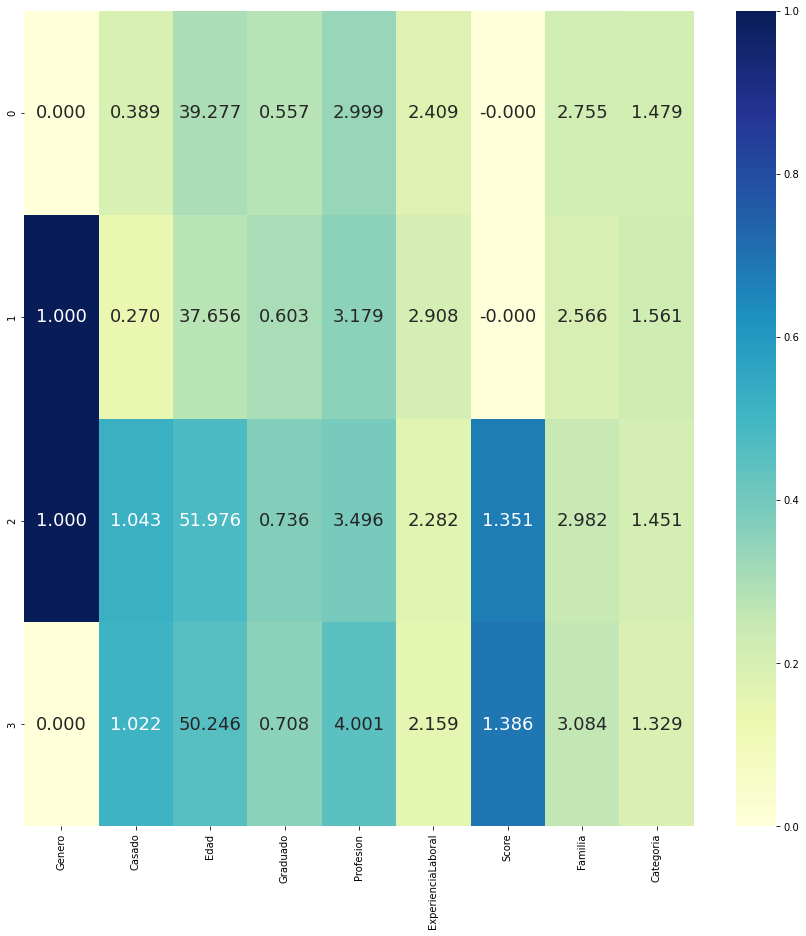

In [85]:
hm_kmeans= heatmap(centroides_kmeans, centroides_desnormalizados_kmeans)

### 5.2.2 Boxplots

In [87]:
clusters_df_kmeans

,cluster
0,0
1,2
2,1
3,3
4,2
...,...
8063,0
8064,0
8065,1
8066,1


In [88]:
boxplot_kmeans = boxplot(df_normalizado_kmeans_clusters,k_kmeans, colors_kmeans,axes_kmeans, centroides_desnormalizados_meanshift_sort,datos_sin_ID.columns)
fig_1.set_size_inches(15,15)

/var/folders/xd/fxn93xyj4dd7b1_k2vddbw000000gn/T/ipykernel_58784/1765287831.py:68: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axes[i,j].grid(axis='y', b=False)
/var/folders/xd/fxn93xyj4dd7b1_k2vddbw000000gn/T/ipykernel_58784/1765287831.py:68: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axes[i,j].grid(axis='y', b=False)
/var/folders/xd/fxn93xyj4dd7b1_k2vddbw000000gn/T/ipykernel_58784/1765287831.py:68: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  axes[i,j].grid(axis='y', b=False)
/var/folders/xd/fxn93xyj4dd7b1_k2vddbw000000gn/T/ipykernel_58784/1765287831.py:68: MatplotlibDeprecationWarning: The 'b' 

IndexError: index 2 is out of bounds for axis 0 with size 2

### 5.2.3 Scatter Matrix

# 6. Reduccion de la dimensionalidad 
As we can see, we have 9 features in our dataset. Sometimes it is difficult both to solve the clustering problem and to visualize the data with a lot of features in it. That's why I decided to try **reduce data dimension** and check what will happen in this case.

This operation will be made with the help of **(Principal Component Analysis) PCA** method. 



In [19]:
# reduce data only to 2 features
pca = PCA(n_components=2).fit_transform(X_train.copy())
# chech result shape
pca.shape

(8068, 2)

In [20]:
# check the results
print(pca[:3])

[[ 0.30755308 -0.65330463]
 [-0.45827018  0.38141596]
 [-0.53517677  0.14336351]]


## 6.1 Mineria de datos. Clustering.

In [21]:
# initialize k-means
kmeans = KMeans(n_clusters=K, random_state=0, max_iter=ITERS, n_init=RUNS, verbose=False)

# predict the labels of clusters
labels = kmeans.fit_predict(pca)
print("- labels = ", labels)

- labels =  [0 3 1 ... 1 1 2]


In [22]:
pca_res = pd.DataFrame(pca.copy())
pca_res["Cluster"] = labels
pca_res.insert(0, "CustomerID", df["CustomerID"])
pca_res.head()

,CustomerID,0,1,Cluster
0,462809,0.307553,-0.653305,0
1,462643,-0.458270,0.381416,3
2,466315,-0.535177,0.143364,1
3,461735,0.639494,0.649138,2
4,462669,-0.340849,0.784494,3


## 6.2 Visualizacion de resultados con reduccion de dimensionalidad.
As we can see, it is easier to visualize data, when we have 2 dimensions. And the results much prettier.

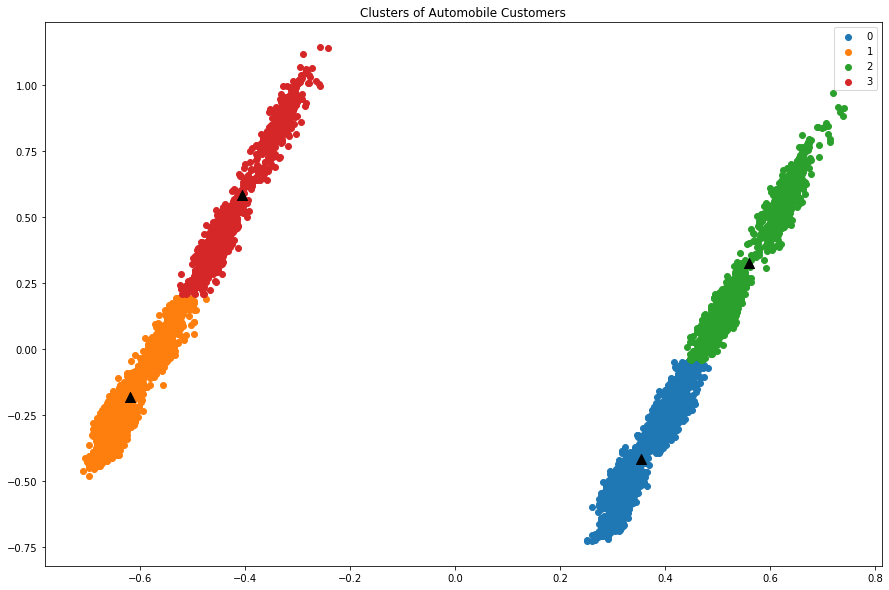

In [23]:
# get the centroids
centroids = kmeans.cluster_centers_
u_labels = np.unique(labels)

# plot the results:
plt.figure(figsize=(15,10))
for i in u_labels:
    mask = (pca_res["Cluster"] == i)
    plt.scatter(pca_res.loc[mask][0], pca_res.loc[mask][1], label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 100, color = 'k', marker="^")
plt.title('Clusters of Automobile Customers')
plt.legend()
plt.show()